# 📘 Проект:  Предсказание энергоэффективности строения

**Данные:** характеристики зданий скрытые за переменными X1-X8

**Модель:** базовые ML-алгоритмы регрессии (линейные модели, градиентный бустинг, случайный лес)

**Метрики:** RMSE, MAE, R²  

**Цель:** построить модель ready-to-use, которая по параметрам здания прогнозирует его уровень энергопотребления
или класс энергоэффективности).




### Почему это важно?
Точный прогноз помогает:
- Оценивать расходы на отопление и электроэнергию ещё на этапе проектирования  
- Планировать реконструкцию и модернизацию зданий  
- Разрабатывать программы энергосбережения и уменьшать углеродный след

### Дальнейшие шаги
- Добавление внешних данных (погода, цены на энергоресурсы)  
- Очистка "лишних" переменных для упрощения сбора данных.


In [ ]:
import pandas as pd

df = pd.read_csv("/kaggle/input/eergy-efficiency-dataset/ENB2012_data.csv")

In [ ]:
df.columns = [
    'Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area',
    'Overall_Height', 'Orientation', 'Glazing_Area', 'Glazing_Area_Dist',
    'targ_Heating_Load', 'targ_Cooling_Load'
]

In [ ]:


categorical_features = ['Orientation', 'Glazing_Area_Dist']
for col in categorical_features:
    df[col] = df[col].astype('category')

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


## 0.1. Перевод числовые <-> категориальные

Логика:

    - если числовое:
        если мало значение И нет линейный зависимоти, типа 1 > 2 - перевод   
        
    - если категория:
        если много значения И есть линейная зависимостть
        

In [ ]:
categorical_cols = []
numeric_cols = []

for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            numeric_cols.append(col)
        else:
            categorical_cols.append(col)

print(numeric_cols)
print(categorical_cols)

['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height', 'Glazing_Area', 'targ_Heating_Load', 'targ_Cooling_Load']
['Orientation', 'Glazing_Area_Dist']


Числовые признаки:

Relative_Compactness — нормализованный показатель, скорее всего линейный.

Surface_Area, Wall_Area, Roof_Area, Overall_Height — геометрические параметры, почти наверняка линейно связаны с теплопотерями и нагрузкой.

Glazing_Area — площадь стекла, влияет на теплообмен прямо → линейная зависимость.

Heating_Load, Cooling_Load — целевые переменные, зависят от всех вышеперечисленных → линейные по определению в модели.



Вывод: всё оставить численным, с линейной зависимостью.

---


Категориальные признаки:


Orientation — направление сторон света. Это дискретная категория (север, юг...), численно кодировать — плохо. Лучше one-hot.

Glazing_Area_Dist — распределение остекления (в какую сторону), тоже дискретная категория.

In [ ]:
th = 5
for col in df.columns:
    if pd.api.types.is_numeric_dtype(df[col]):
        n_unique = df[col].nunique()
        if n_unique < th:

            print(f"{col}: {n_unique} - недостаточно значений")

Roof_Area: 4 - недостаточно значений
Overall_Height: 2 - недостаточно значений
Glazing_Area: 4 - недостаточно значений


# Анализ

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Relative_Compactness  768 non-null    float64 
 1   Surface_Area          768 non-null    float64 
 2   Wall_Area             768 non-null    float64 
 3   Roof_Area             768 non-null    float64 
 4   Overall_Height        768 non-null    float64 
 5   Orientation           768 non-null    category
 6   Glazing_Area          768 non-null    float64 
 7   Glazing_Area_Dist     768 non-null    category
 8   targ_Heating_Load     768 non-null    float64 
 9   targ_Cooling_Load     768 non-null    float64 
dtypes: category(2), float64(8)
memory usage: 50.0 KB
None

Missing values:
 Relative_Compactness    0
Surface_Area            0
Wall_Area               0
Roof_Area               0
Overall_Height          0
Orientation             0
Glazing_Area            0
Glazing_Area

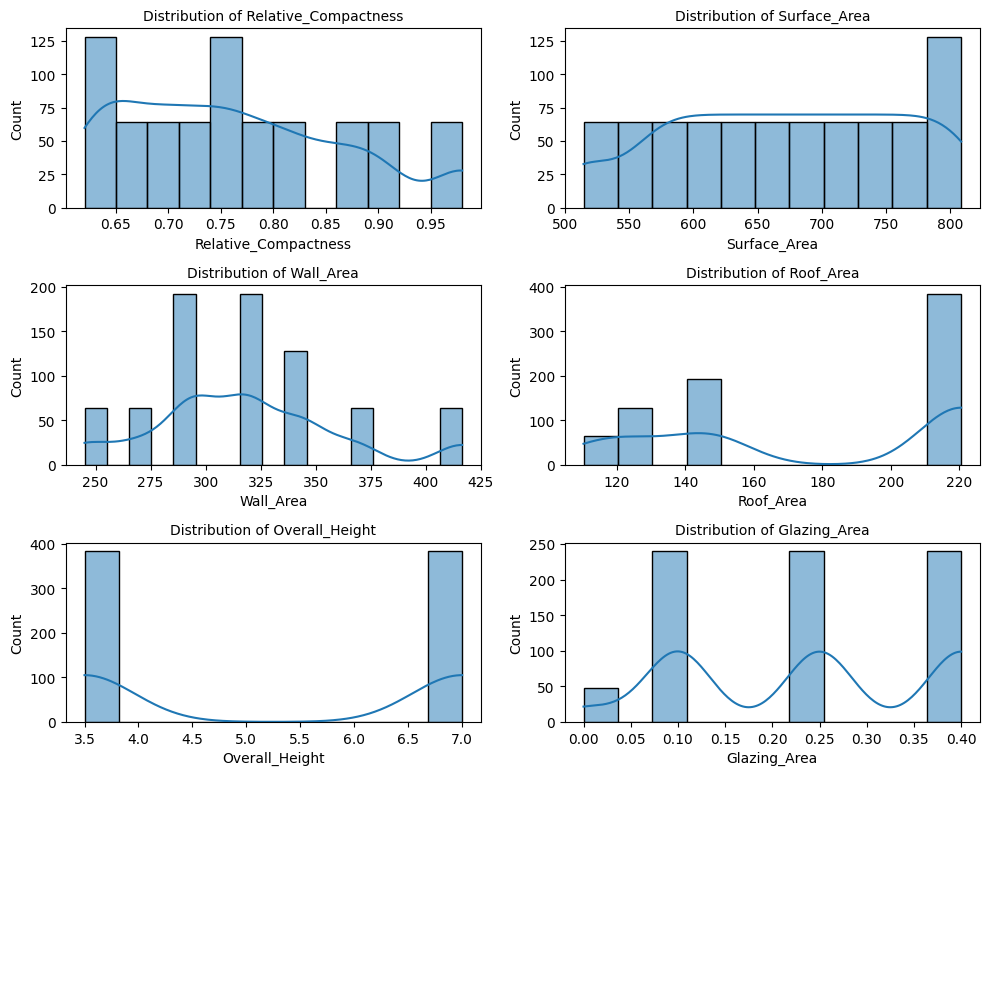

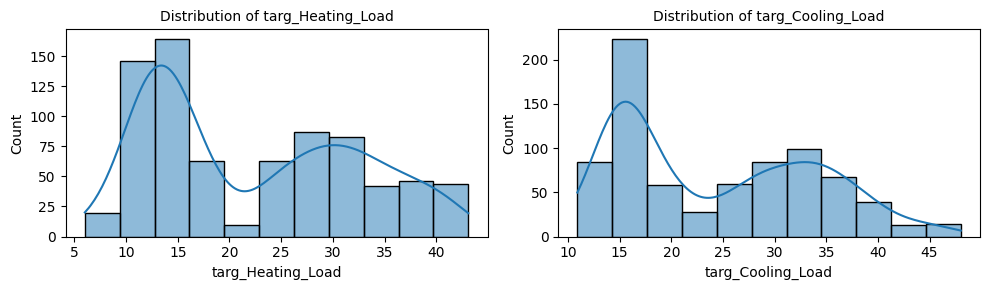

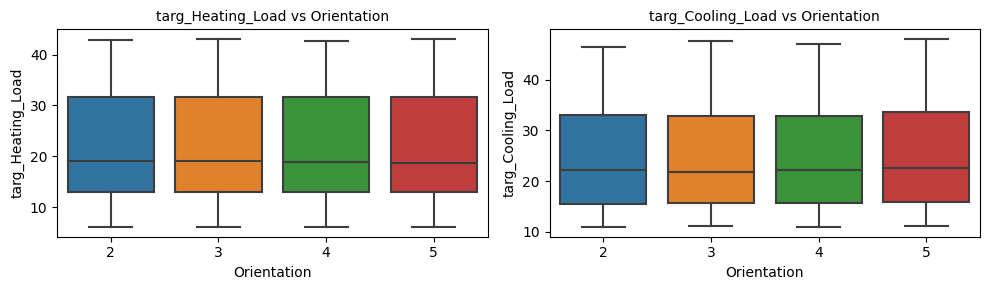

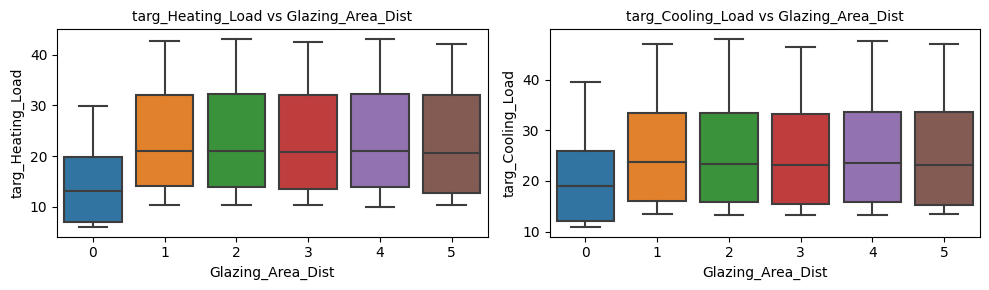

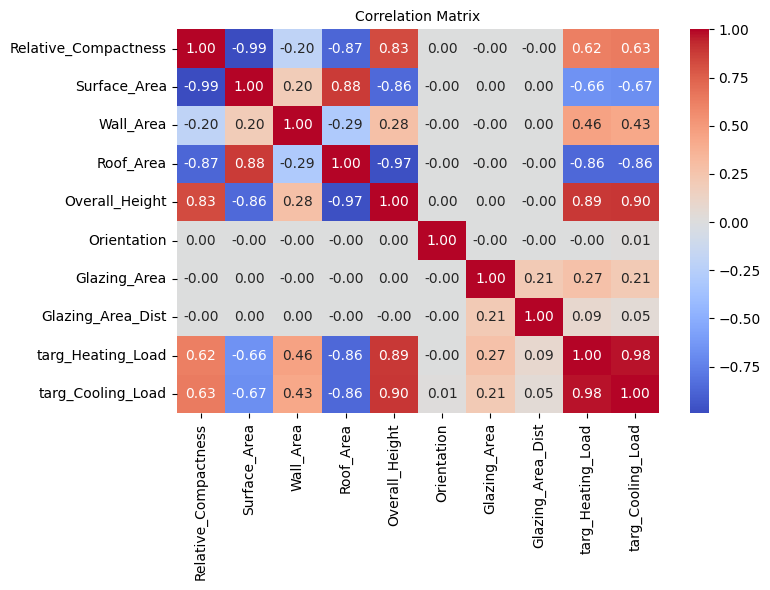

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



VIF:
                 feature         VIF
0  Relative_Compactness  105.524054
1          Surface_Area         inf
2             Wall_Area         inf
3             Roof_Area         inf
4        Overall_Height   31.205474
5          Glazing_Area    1.000000


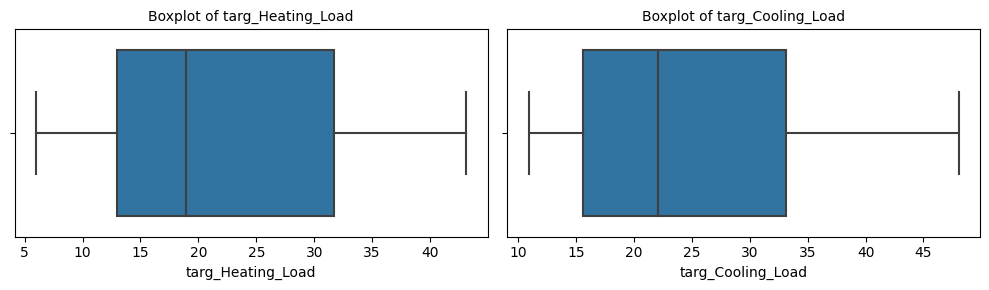

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# --- Пропуски и дубликаты ---
print(df.info())
print("\nMissing values:\n", df.isna().sum())
print("\nDuplicated rows:", df.duplicated().sum())

# --- Статистика ---
print(df.describe().T)

# --- Распределения признаков (2 графика в строку) ---
num_features = df.select_dtypes(include=[np.number]).drop(columns=['targ_Heating_Load', 'targ_Cooling_Load']).columns
fig, axes = plt.subplots(nrows=len(num_features) // 2 + 1, ncols=2, figsize=(10, 10))
axes = axes.flatten()
for i, col in enumerate(num_features):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}', fontsize=10)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()

# --- Распределения целей (2 в ряд) ---
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
for i, target in enumerate(['targ_Heating_Load', 'targ_Cooling_Load']):
    sns.histplot(df[target], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {target}', fontsize=10)
plt.tight_layout()
plt.show()

# --- Boxplot категорий (по 2 графика в строку) ---
for cat in categorical_features:
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    for i, target in enumerate(['targ_Heating_Load', 'targ_Cooling_Load']):
        sns.boxplot(x=df[cat], y=df[target], ax=axes[i])
        axes[i].set_title(f'{target} vs {cat}', fontsize=10)
    plt.tight_layout()
    plt.show()

# --- Корреляционная матрица ---
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix", fontsize=10)
plt.tight_layout()
plt.show()


# --- VIF ---
X_vif = df[num_features].copy()
X_vif = StandardScaler().fit_transform(X_vif)
vif_data = pd.DataFrame()

vif_data["feature"] = num_features
vif_data["VIF"] = [variance_inflation_factor(X_vif, i) for i in range(X_vif.shape[1])]
print("\nVIF:\n", vif_data)

# --- Boxplot по таргетам (2 в ряд) ---
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
for i, target in enumerate(['targ_Heating_Load', 'targ_Cooling_Load']):
    sns.boxplot(x=df[target], ax=axes[i])
    axes[i].set_title(f'Boxplot of {target}', fontsize=10)
plt.tight_layout()
plt.show()

### Из-за высокой корреляции между Heating_Load и Cooling_Load (0.98) в демонстрационных целях обучена только одна модель, так как выводы и препроцессинг для второй аналогичны — это экономит ресурсы и снижает дублирование.

In [ ]:
df = df.drop('targ_Cooling_Load', axis=1)

## Вывод по данным:

### 📌 Особенности данных
    - Нет пропусков, дубликатов — df.info(), df.isna(), df.duplicated()
    
    - Heating/Cooling Load — правоскошены (гистограммы)

    - Glazing_Area, Overall_Height — фактически категориальные (гистограммы)

    - Orientation, Glazing_Area_Dist — слабое влияние на цели (boxplot)

    - Surface/Wall/Roof Area → мультиколлинеарны (heatmap, VIF = ∞)

### ✅ Действия
    - Удалим часть столбцов для избежания мультиколлинеарности

    - Умное маштабирование (только для лин. моделей)

    - Добавим новые фичи, например Window_Effect = Glazing_Area × Relative_Compactness


# Предобработка


In [ ]:
def generate_engineered_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Избегаем деления на ноль
    eps = 1e-6

    df["new_glazing_ratio"] = df["Glazing_Area"] / (df["Surface_Area"] + eps)
    df["new_wall_ratio"] = df["Wall_Area"] / (df["Surface_Area"] + eps)
    df["new_roof_ratio"] = df["Roof_Area"] / (df["Surface_Area"] + eps)
    df["new_wall_to_roof"] = df["Wall_Area"] / (df["Roof_Area"] + eps)
    df["new_glazing_to_wall"] = df["Glazing_Area"] / (df["Wall_Area"] + eps)

    df["new_volume"] = df["Surface_Area"] * df["Overall_Height"]
    df["new_area_per_height"] = df["Surface_Area"] / (df["Overall_Height"] + eps)
    df["new_compactness_proxy"] = df["new_volume"] / (df["Surface_Area"] + eps)

    return df
# Применим генерацию признаков
df_engineered = generate_engineered_features(df)

In [ ]:
df.columns

Index(['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area',
       'Overall_Height', 'Orientation', 'Glazing_Area', 'Glazing_Area_Dist',
       'targ_Heating_Load'],
      dtype='object')

### 1.1 Добавялем фичи

In [ ]:
df_engineered.columns

Index(['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area',
       'Overall_Height', 'Orientation', 'Glazing_Area', 'Glazing_Area_Dist',
       'targ_Heating_Load', 'new_glazing_ratio', 'new_wall_ratio',
       'new_roof_ratio', 'new_wall_to_roof', 'new_glazing_to_wall',
       'new_volume', 'new_area_per_height', 'new_compactness_proxy'],
      dtype='object')

### Убираем мультиколлениарность

Код удаляет признаки с высокой взаимной корреляцией:

    в парах — оставляет сильнее связанные с целью,
    в группах — два с наименьшей корреляцией между собой.

In [ ]:
import pandas as pd
import numpy as np

# Копия исходного датафрейма
df = df_engineered.copy()
target_col = 'targ_Heating_Load'

# Сохраняем список категориальных признаков
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Выделяем только числовые признаки (кроме таргета)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != target_col]

# Строим корреляционную матрицу
corr_matrix = df[numeric_cols].corr().abs()

# Группируем признаки с корреляцией выше порога
threshold = 0.9
groups = []
used = set()

for col in corr_matrix.columns:
    if col in used:
        continue
    high_corr = corr_matrix[col][(corr_matrix[col] > threshold) & (corr_matrix.index != col)].index.tolist()
    group = set(high_corr + [col])
    if len(group) > 1 and group not in groups:
        groups.append(group)
        used.update(group)

# Оставляем лучшие признаки в каждой группе
to_keep = set()
for group in groups:
    group = list(group)
    if len(group) == 2:
        corr_with_target = [abs(df[feat].corr(df[target_col])) for feat in group]
        to_keep.add(group[np.argmax(corr_with_target)])
    else:
        min_corr = 1
        best_pair = (group[0], group[1])
        for i in range(len(group)):
            for j in range(i + 1, len(group)):
                c = corr_matrix.loc[group[i], group[j]]
                if c < min_corr:
                    min_corr = c
                    best_pair = (group[i], group[j])
        to_keep.update(best_pair)

# Формируем финальный DataFrame
final_numeric = df[list(to_keep | {target_col})]
df_final = pd.concat([final_numeric, df[categorical_cols]], axis=1)
df = df_final.copy()

In [ ]:
df.columns

Index(['targ_Heating_Load', 'new_wall_to_roof', 'Surface_Area',
       'Overall_Height', 'new_glazing_to_wall', 'new_area_per_height',
       'new_glazing_ratio', 'new_volume', 'Orientation', 'Glazing_Area_Dist'],
      dtype='object')

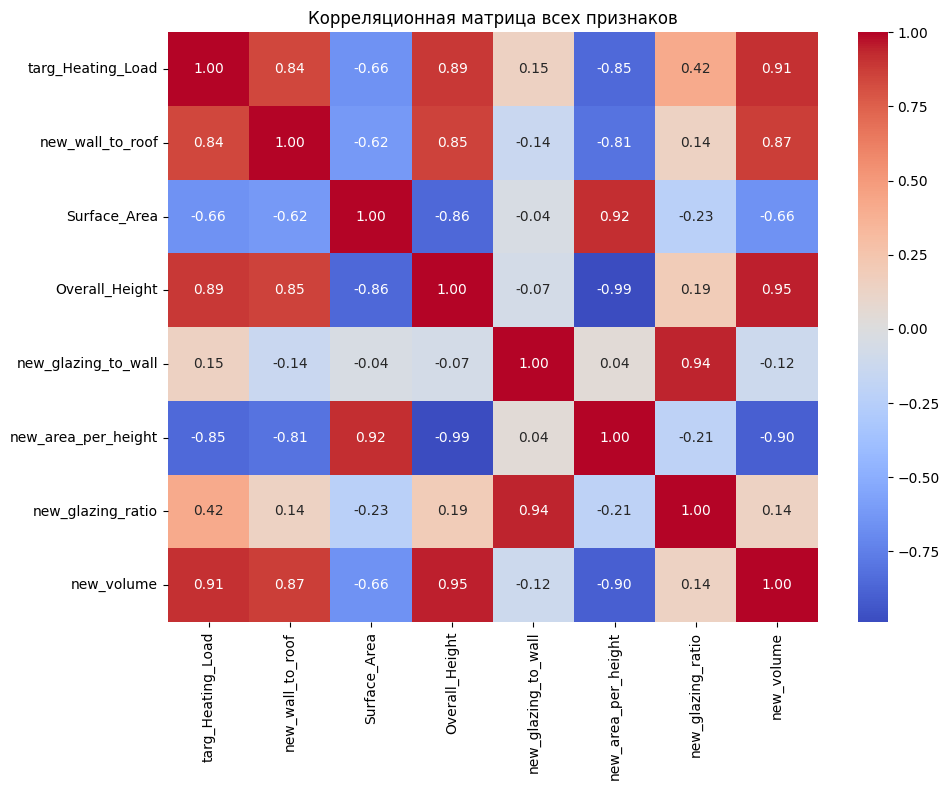

In [ ]:
# Корреляционная матрица
corr_matrix = df.corr(numeric_only=True)

# Построим тепловую карту
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Корреляционная матрица всех признаков")
plt.tight_layout()
plt.show()

## Универсальная предобротка
    - заполняем пропуски
    - удаляем столбцы с константами


* универсальная значит подходит для линейных и tree-based моделей

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import pandas as pd


def base_preprocessing(df):
    X = df.drop('targ_Heating_Load', axis=1)
    y = df['targ_Heating_Load']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

    def universal_preprocessing(X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()

        # Удаление константных фичей
        nunique = X.nunique()
        const_cols = nunique[nunique <= 1].index
        X.drop(columns=const_cols, inplace=True)

        return X


    # --- предобработка (удаление констант и т. д.)
    X_train = universal_preprocessing(X_train)
    X_test = X_test[X_train.columns]  # подгоняем под те же столбцы

    # --- импутация (медиана только по train)
    median_imputer = SimpleImputer(strategy='median')
    X_train = pd.DataFrame(median_imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(median_imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = base_preprocessing(df)

### Подозрительными оказались три столбца. Но из рассжуждения выше ясно, что столбцы имеют линейную зависимость -> Перевод в категориальные переменные не требуется.

## Пайплайн с линейными моделями (ridge, lasso, elasticnet)

### One-hot encoding

In [ ]:
X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

### Маштабирование

Важно: только для линейных моделей: linear reg, lasso, log reg etc. Т.к. маштабирование для tree-based methods либо не нужно, а как правило ухудшает работу моделей + снижает интерпретируемость.

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import skew



def analyze_scaling_needs(df: pd.DataFrame, exclude_cols=None) -> pd.DataFrame:
    if exclude_cols is None:
        exclude_cols = []

    results = []

    for col in df.columns:
        if col in exclude_cols:
            continue  # Пропускаем исключённые колонки

        if not pd.api.types.is_numeric_dtype(df[col]):
            continue  # Пропускаем категориальные и булевы

        x = df[col].dropna()
        if len(x) < 10:
            continue  # Пропускаем столбцы с слишком малым числом значений

        median = np.median(x)
        mad = np.median(np.abs(x - median))
        safe_median = np.abs(median) + 1e-8

        rcv = mad / safe_median
        skewness = skew(x)
        score = rcv + 0.2 * abs(skewness)

        # Категоризация
        if score < 0.1:
            recommendation = '-'
        elif score < 0.5:
            recommendation = 'StandardScaler'
        else:
            recommendation = 'RobustScaler'

        results.append({
            'column': col,
            'RCV (mad/median)': round(rcv, 4),
            'Skewness': round(skewness, 4),
            'Score': round(score, 4),
            'Recommendation': recommendation
        })

    return pd.DataFrame(results).sort_values(by='Score', ascending=False).reset_index(drop=True)



In [ ]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [ ]:
exclude = [col for col in train.columns if col.startswith('Orientation_') or col.startswith('Glazing_Area_Dist_')]
scaling_report = analyze_scaling_needs(train, exclude_cols=exclude)

In [ ]:
scaling_report

,column,RCV (mad/median),Skewness,Score,Recommendation
0,new_glazing_to_wall,0.5667,0.1407,0.5948,RobustScaler
1,new_glazing_ratio,0.5467,0.1578,0.5782,RobustScaler
2,targ_Heating_Load,0.3930,0.3845,0.4699,StandardScaler
3,new_wall_to_roof,0.2667,0.6437,0.3954,StandardScaler
4,new_volume,0.1515,0.2250,0.1965,StandardScaler
5,new_area_per_height,0.1786,-0.0112,0.1808,StandardScaler
6,Surface_Area,0.1071,-0.1630,0.1397,StandardScaler
7,Overall_Height,0.0000,0.0456,0.0091,-


In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler

def apply_custom_scaling(df: pd.DataFrame, scaling_report: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Разделяем колонки по типу скейлера
    std_cols = scaling_report.loc[scaling_report['Recommendation'] == 'StandardScaler', 'column'].tolist()
    robust_cols = scaling_report.loc[scaling_report['Recommendation'] == 'RobustScaler', 'column'].tolist()

    # Применяем StandardScaler
    if std_cols:
        scaler_std = StandardScaler()
        df[std_cols] = scaler_std.fit_transform(df[std_cols])

    # Применяем RobustScaler
    if robust_cols:
        scaler_robust = RobustScaler()
        df[robust_cols] = scaler_robust.fit_transform(df[robust_cols])

    return df


In [ ]:
train = apply_custom_scaling(train, scaling_report)
test = apply_custom_scaling(train, scaling_report)

In [ ]:
train

,new_wall_to_roof,Surface_Area,Overall_Height,new_glazing_to_wall,new_area_per_height,new_glazing_ratio,new_volume,Orientation_3.0,Orientation_4.0,Orientation_5.0,Glazing_Area_Dist_1.0,Glazing_Area_Dist_2.0,Glazing_Area_Dist_3.0,Glazing_Area_Dist_4.0,Glazing_Area_Dist_5.0,targ_Heating_Load
602,-1.239939,0.147544,3.5,1.026244,0.701345,0.615796,-1.181835,False,True,False,False,True,False,False,False,-0.780322
429,-0.417546,1.554251,3.5,-0.126697,1.242740,-0.113585,-0.662626,True,False,False,False,False,True,False,False,-0.764606
623,-0.417546,1.554251,3.5,0.367421,1.242740,0.380511,-0.662626,False,False,True,False,True,False,False,False,-0.488593
209,0.569327,-0.415139,7.0,-0.597285,-0.922840,-0.518998,1.310369,True,False,False,False,False,False,True,False,1.352146
589,0.322609,-0.696480,7.0,0.570136,-0.976980,0.802141,1.102685,True,False,False,False,True,False,False,False,0.723505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,0.964076,-1.259163,7.0,0.570136,-1.085259,0.953377,0.687318,False,True,False,True,False,False,False,False,1.427780
584,0.075891,-0.977822,7.0,0.696833,-1.031119,0.874608,0.895002,False,False,False,False,True,False,False,False,1.017198
493,0.322609,-0.696480,7.0,0.000000,-0.976980,0.149933,1.102685,True,False,False,False,False,False,False,True,0.299172
527,-0.417546,1.554251,3.5,-0.126697,1.242740,-0.113585,-0.662626,False,False,True,False,False,False,False,True,-0.811754


In [ ]:
X_train = train.drop('targ_Heating_Load', axis=1)
y_train = train['targ_Heating_Load']

X_test = test.drop('targ_Heating_Load', axis=1)
y_test = test['targ_Heating_Load']

In [ ]:
X_train.columns

Index(['new_wall_to_roof', 'Surface_Area', 'Overall_Height',
       'new_glazing_to_wall', 'new_area_per_height', 'new_glazing_ratio',
       'new_volume', 'Orientation_3.0', 'Orientation_4.0', 'Orientation_5.0',
       'Glazing_Area_Dist_1.0', 'Glazing_Area_Dist_2.0',
       'Glazing_Area_Dist_3.0', 'Glazing_Area_Dist_4.0',
       'Glazing_Area_Dist_5.0'],
      dtype='object')

In [ ]:
X_test.columns

Index(['new_wall_to_roof', 'Surface_Area', 'Overall_Height',
       'new_glazing_to_wall', 'new_area_per_height', 'new_glazing_ratio',
       'new_volume', 'Orientation_3.0', 'Orientation_4.0', 'Orientation_5.0',
       'Glazing_Area_Dist_1.0', 'Glazing_Area_Dist_2.0',
       'Glazing_Area_Dist_3.0', 'Glazing_Area_Dist_4.0',
       'Glazing_Area_Dist_5.0'],
      dtype='object')

## 4.1 Обучения линейных моделей с Optuna + multiproccessing

In [ ]:
# Пока сгенерируем фиктивные данные для теста
from sklearn.datasets import make_regression
import optuna
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed

In [ ]:
import multiprocessing
# Определяем количество ядер, но оставляем одно ядро свободным
available_cpus = max(1, multiprocessing.cpu_count() - 1)

In [ ]:
# Оптимизация под одну модель
def objective(trial, model_type):
    if model_type == "ridge":
        alpha = trial.suggest_float("alpha", 1e-3, 10.0, log=True)
        solver = trial.suggest_categorical("solver", ["auto", "svd", "cholesky"])
        model = Ridge(alpha=alpha, solver=solver, random_state=1)
    elif model_type == "lasso":
        alpha = trial.suggest_float("alpha", 1e-3, 10.0, log=True)
        selection = trial.suggest_categorical("selection", ["cyclic", "random"])
        model = Lasso(alpha=alpha, selection=selection, random_state=1, max_iter=10000)
    elif model_type == "elasticnet":
        alpha = trial.suggest_float("alpha", 1e-3, 10.0, log=True)
        l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=1, max_iter=10000)
    else:
        raise ValueError("Unsupported model")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    loss = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
    return loss

# Запуск Optuna для всех моделей
def run_optuna_for_model(model_type):
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, model_type), n_trials=50)
    return model_type, study.best_trial.value, study.best_params

# Параллельный запуск
results = Parallel(n_jobs=available_cpus)(
    delayed(run_optuna_for_model)(model) for model in ["ridge", "lasso", "elasticnet"]
)

# Сохраняем в DataFrame
lin_results_df = pd.DataFrame(results, columns=["Model", "Best RMSE", "Best Params"])


[I 2025-06-21 04:59:44,812] A new study created in memory with name: no-name-53b1426b-05f1-468c-a2a0-4b2e8b112a34
[I 2025-06-21 04:59:44,816] A new study created in memory with name: no-name-44414eff-e249-4f02-a1f4-918556a0a22b
[I 2025-06-21 04:59:44,819] A new study created in memory with name: no-name-8fa66b42-4753-49ca-bc94-f1dd604b702b
[I 2025-06-21 04:59:44,822] Trial 0 finished with value: 0.24828725663501636 and parameters: {'alpha': 0.009537325272605673, 'solver': 'cholesky'}. Best is trial 0 with value: 0.24828725663501636.
[I 2025-06-21 04:59:44,826] Trial 0 finished with value: 0.7133772154242509 and parameters: {'alpha': 0.9621303502528175, 'selection': 'random'}. Best is trial 0 with value: 0.7133772154242509.
[I 2025-06-21 04:59:44,826] Trial 0 finished with value: 0.29485852833410336 and parameters: {'alpha': 0.09869319284278931, 'l1_ratio': 0.13762175332214122}. Best is trial 0 with value: 0.29485852833410336.
[I 2025-06-21 04:59:44,829] Trial 1 finished with value: 0.2

In [ ]:
lin_results_df

,Model,Best RMSE,Best Params
0,ridge,0.248287,"{'alpha': 0.0010056135894411767, 'solver': 'ch..."
1,lasso,0.252533,"{'alpha': 0.0010063752151210801, 'selection': ..."
2,elasticnet,0.249828,"{'alpha': 0.0010847389621486355, 'l1_ratio': 0..."


### 4.2 Тест моделей с разными метриками
    - RMSE
    - MAE     
    - R2

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
import pandas as pd
import numpy as np

# X_train, X_test, y_train, y_test — должны быть уже готовы
# resu_df — твоя таблица: Model | Best RMSE | Best Params

model_map = {
    'ridge': Ridge,
    'lasso': Lasso,
    'elasticnet': ElasticNet
}

results = []

for _, row in lin_results_df.iterrows():
    model_name = row['Model']
    params = row['Best Params']
    model_cls = model_map[model_name]

    model = model_cls(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': model_name,
        'RMSE': round(rmse, 4),
        'MAE': round(mae, 4),
        'R2': round(r2, 4)
    })

lin_metrics_df = pd.DataFrame(results)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.729e-02, tolerance: 6.140e-02
  model = cd_fast.enet_coordinate_descent(


In [ ]:
print(lin_metrics_df)

        Model    RMSE     MAE      R2
0       ridge  0.2483  0.1726  0.9384
1       lasso  0.2525  0.1748  0.9362
2  elasticnet  0.2496  0.1713  0.9377


## 5.1 Обучение tree-based моделей


*без маштабирование и энкодинга (не требуется для такого типа моделей)

In [ ]:
X_train, X_test, y_train, y_test = base_preprocessing(df)

In [ ]:
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from joblib import Parallel, delayed
import pandas as pd
import numpy as np


# Список моделей
models = {
    "HistGradientBoosting": HistGradientBoostingRegressor,
    "CatBoost": CatBoostRegressor,
    "XGBoost": XGBRegressor,
    "LightGBM": LGBMRegressor,
}

def objective(trial, model_name):
    if model_name == "HistGradientBoosting":
        params = {
            "max_iter": trial.suggest_int("max_iter", 100, 1000),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "l2_regularization": trial.suggest_float("l2_regularization", 0.0, 5.0),
        }
        model = HistGradientBoostingRegressor(**params)

    elif model_name == "CatBoost":
        params = {
            "iterations": trial.suggest_int("iterations", 100, 1000),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "depth": trial.suggest_int("depth", 3, 10),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
            "verbose": 0,
        }
        model = CatBoostRegressor(**params)

    elif model_name == "XGBoost":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
        }
        model = XGBRegressor(**params)

    elif model_name == "LightGBM":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
            'verbosity': -1
        }
        model = LGBMRegressor(**params)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)


    rmse = mean_squared_error(y_test, y_pred, squared=False)
    return rmse

def optimize_model(model_name):
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, model_name), n_trials=50, n_jobs=available_cpus)
    return model_name, study.best_value, study.best_params

# Параллельная оптимизация
results = Parallel(n_jobs=-1)(
    delayed(optimize_model)(model_name) for model_name in models
)

# Вывод результатов
tree_results_df = pd.DataFrame(results, columns=["Model", "Best RMSE", "Best Params"])


[I 2025-06-29 13:20:50,526] A new study created in memory with name: no-name-3ad5abce-fa78-44fd-9d81-b0e02f69f143
[I 2025-06-29 13:20:50,559] A new study created in memory with name: no-name-5ab2f7d3-cbef-453a-814a-592a8286f3cc
[I 2025-06-29 13:20:50,595] A new study created in memory with name: no-name-9b1b6d69-f865-4553-b3da-517d1bfbbc54


NameError: name 'available_cpus' is not defined

In [ ]:
tree_results_df

,Model,Best RMSE,Best Params
0,HistGradientBoosting,0.391051,"{'max_iter': 665, 'learning_rate': 0.214103458..."
1,CatBoost,0.343352,"{'iterations': 660, 'learning_rate': 0.2962892..."
2,XGBoost,0.391346,"{'n_estimators': 981, 'learning_rate': 0.04728..."
3,LightGBM,0.393414,"{'n_estimators': 770, 'learning_rate': 0.13674..."


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import pandas as pd

# Сопоставление имён моделей с классами
model_map = {
    "HistGradientBoosting": HistGradientBoostingRegressor,
    "CatBoost": CatBoostRegressor,
    "XGBoost": XGBRegressor,
    "LightGBM": LGBMRegressor
}

results = []

import contextlib
import os
import sys

@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

for _, row in tree_results_df.iterrows():
    model_name = row['Model']
    params = row['Best Params']
    model_cls = model_map[model_name]

    model = model_cls(**params)

    with suppress_output():  # <<< вот здесь всё подавляется
        model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': model_name,
        'RMSE': round(rmse, 4),
        'MAE': round(mae, 4),
        'R2': round(r2, 4)
    })

tree_metrics_df = pd.DataFrame(results)


NameError: name 'tree_results_df' is not defined

In [ ]:
tree_metrics_df

,Model,RMSE,MAE,R2
0,HistGradientBoosting,0.3911,0.2664,0.9984
1,CatBoost,0.3434,0.2046,0.9987
2,XGBoost,0.3913,0.2570,0.9984
3,LightGBM,0.3934,0.2569,0.9983


In [ ]:
final_metrics_df = pd.concat([tree_metrics_df, lin_metrics_df])

In [ ]:
final_metrics_df

,Model,RMSE,MAE,R2
0,HistGradientBoosting,0.3911,0.2664,0.9984
1,CatBoost,0.3434,0.2046,0.9987
2,XGBoost,0.3913,0.2570,0.9984
3,LightGBM,0.3934,0.2569,0.9983
0,ridge,0.2483,0.1726,0.9384
1,lasso,0.2525,0.1748,0.9362
2,elasticnet,0.2496,0.1713,0.9377


## 🔍 Итоги проекта

Задача: предсказание теплопотерь зданий на основе архитектурных параметров.

---

### 🔧 Что было сделано

- Предобработка:
  - удаление констант;
  - заполнение пропусков;
  - one-hot/ordinal encoding;
  - масштабирование (только для линейных);
  - фильтрация коллинеарных признаков (только для линейных).
- Подбор гиперпараметров через Optuna.
- Оценка на тесте: RMSE, MAE, R².
- Модели:
  - линейные: `Ridge`, `Lasso`, `ElasticNet`
  - деревья: `CatBoost`, `XGBoost`, `LightGBM`, `HistGBR`
    
---

### 📊 Результаты

| Model                | RMSE   | MAE    | R²     |
|----------------------|--------|--------|--------|
| Ridge                | 0.2483 | 0.1726 | 0.9384 |
| Lasso                | 0.2525 | 0.1748 | 0.9362 |
| ElasticNet           | 0.2496 | 0.1713 | 0.9377 |
| CatBoost             | 0.3434 | 0.2046 | 0.9987 |
| XGBoost              | 0.3913 | 0.2570 | 0.9984 |
| LightGBM             | 0.3934 | 0.2569 | 0.9983 |
| HistGradientBoosting | 0.3911 | 0.2664 | 0.9984 |

---

### 💡 Выводы

- **Лучшие результаты показали линейные модели**, несмотря на использование современных ансамблей.
- Это стало возможным благодаря **грамотной предобработке**:
  - масштабирование,
  - удаление избыточных признаков,
  - корректная работа с категориальными переменными.
- **Ridge-регрессия** продемонстрировала лучший RMSE (0.2483), опередив более сложные модели.

---

### 📈 Бизнес-польза

- Линейные модели **быстрее обучаются**, **дешевле внедряются**, проще в интерпретации.
- **Процесс подготовки данных** критичен — он может дать больше прироста качества, чем усложнение модели.
- Подход пригоден для **легковесных решений**, **аналитических дашбордов** или **реального времени** (в продакшене).

---

### ✅ Заключение
ЛуЛучшая модель показывает RMSE (0.2483) — это **хороший, но не идеальный** результат.
Логичный шаг: увеличить выборку или добавить переменные.
К сожалению, сделать это не под силу мне, однако не стоит унывать — RMSE = 0.25, R² = 0.93 всё ещё приемлемый результат для применения в реальных условиях.
Задачу можно назвать успешно выполненной.
